In [14]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
X_art_train,X_art_test,y_art_train,y_art_test=eval_models.get_train_test("artificial")

## No standarization at all

In [19]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train.values,y_art_train)
X_art_train_boruta=X_art_train.iloc[:,feat_select.support_]
X_art_test_boruta=X_art_test.iloc[:,feat_select.support_]

KeyboardInterrupt: 

In [ ]:
noscaling_res=eval_models.get_models_ba(X_art_train_boruta,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

In [ ]:
plt.figure(figsize=(12,12))
corr = X_art_train_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

In [ ]:
X_train_no_corr=eval_models.delete_corr(X_art_train_boruta)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

## Standarization after Boruta (not really expecting it to work)

In [ ]:
X_art_train_boruta_sc,X_art_test_boruta_sc=eval_models.standarize(X_art_train_boruta,X_art_test_boruta)

In [ ]:
X_train_no_corr2=eval_models.delete_corr(X_art_train_boruta_sc)

In [ ]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_art_test_boruta_sc,
                              y_art_train,
                              y_art_test
                             )

## Standarization before Boruta

In [ ]:
X_art_train_sc,X_art_test_sc=eval_models.standarize(X_art_train,X_art_test)

In [ ]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train_sc.values,y_art_train)
X_art_train_sc_boruta=X_art_train_sc.iloc[:,feat_select.support_]
X_art_test_sc_boruta=X_art_test_sc.iloc[:,feat_select.support_]

In [ ]:
scaled_res=eval_models.get_models_ba(X_art_train_sc_boruta,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

In [ ]:
plt.figure(figsize=(12,12))
corr = X_art_train_sc_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

In [ ]:
X_art_train_sc_no_corr=eval_models.delete_corr(X_art_train_sc_boruta)

In [ ]:
scaled_res_cor=eval_models.get_models_ba(X_art_train_sc_no_corr,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

## Cross validation (with standarization before Boruta)

In [22]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_art_train)):
    X_train=X_art_train.iloc[train_idx,:]
    X_val=X_art_train.iloc[val_idx,:]
    y_train=y_art_train[train_idx]
    y_val=y_art_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    

    with open('../data/boruta/artificial-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

0it [00:00, ?it/s]

LogisticRegression 0.628
RandomForestClassifier 0.8998
AdaBoostClassifier 0.6237
LGBMClassifier 0.8561


1it [00:30, 30.74s/it]

XGBClassifier 0.8631
9  features in the dataset
LogisticRegression 0.5996
RandomForestClassifier 0.8599
AdaBoostClassifier 0.6498
LGBMClassifier 0.8532


2it [01:11, 36.88s/it]

XGBClassifier 0.8532
9  features in the dataset
LogisticRegression 0.5931
RandomForestClassifier 0.8367
AdaBoostClassifier 0.6565
LGBMClassifier 0.8335


3it [02:16, 49.56s/it]

XGBClassifier 0.8534
10  features in the dataset
LogisticRegression 0.6052
RandomForestClassifier 0.8453
AdaBoostClassifier 0.5972
LGBMClassifier 0.8374


4it [03:12, 51.97s/it]

XGBClassifier 0.8129
10  features in the dataset
LogisticRegression 0.5699
RandomForestClassifier 0.8431
AdaBoostClassifier 0.6534
LGBMClassifier 0.8365


5it [04:08, 49.62s/it]

XGBClassifier 0.8466
12  features in the dataset


In [26]:
pd.concat(models_res, ignore_index=1).groupby(by='Classifier').mean().sort_values(by="BA score")

,BA score
Classifier,
LogisticRegression,0.599155
AdaBoostClassifier,0.636104
LGBMClassifier,0.843344
XGBClassifier,0.845860
RandomForestClassifier,0.856950


In conclusion we could expect sth around 0.84 balanced accuracy score with 10 features.
We could use some other method to select only the 5 best ones. Nie wiem czy jest sens bo użycie 10 zamiast 5 to kara na poziomie 1 punktu procentowego

### Having run Boruta x times we will select only those variables which have been selected at least 95% of the time
remember to specify x_times!

In [3]:
boruta_all_results=pd.read_csv('../data/boruta/artificial-features.csv',header=None,sep="\n")
x_times=boruta_all_results.shape[0]
boruta_all_results=boruta_all_results.iloc[:,0].str.split(',', expand=True)

In [4]:
boruta_all_array=np.array(list(filter(None, np.array(boruta_all_results).flatten()))).astype(np.int64)
unique, counts=np.unique(np.array(boruta_all_array).flatten(),return_counts=True)
columns_boruta= unique[counts>=x_times*0.95]

In [5]:
X_art_train_boruta_multiple=X_art_train.iloc[:,columns_boruta]
X_art_train_boruta_multiple.head()

,28,48,64,105,128,153,241,281,318,336,338,378,433,442,451,453,472,475,493
508,468,537,588,484,478,517,425,487,443,602,573,548,509,613,469,625,533,377,636
242,493,434,468,554,484,681,534,563,530,451,343,434,625,377,488,526,415,529,546
1024,493,497,301,755,500,433,578,448,529,278,389,516,451,440,485,453,458,612,464
782,503,434,367,612,490,445,527,452,555,327,441,409,459,471,491,460,470,521,473
677,479,504,586,454,475,596,489,533,482,584,472,524,576,434,477,489,447,475,506


Results without standarization and removing based on VIF

In [6]:
eval_models.get_models_ba(X_art_train_boruta_multiple,
                              X_art_test,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )

LogisticRegression 0.642
RandomForestClassifier 0.88
AdaBoostClassifier 0.622
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.642
1,RandomForestClassifier,0.880
2,AdaBoostClassifier,0.622
3,LGBMClassifier,0.878
4,XGBClassifier,0.876


Now we standarize both sets and remove some variables based on VIF

In [7]:
X_art_train_scaled,X_art_test_scaled=eval_models.standarize(X_art_train,X_art_test)
X_art_train_scaled_boruta_multiple=X_art_train_scaled.iloc[:,columns_boruta]

In [8]:
res_boruta_no_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )
res_boruta_no_vif['VIF']="No"

LogisticRegression 0.638
RandomForestClassifier 0.89
AdaBoostClassifier 0.618
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


In [9]:
X_art_train_scaled_boruta_multiple_vif=eval_models.delete_multicollinear(X_art_train_scaled_boruta_multiple)

18
17
16
15
14
13
12
11
10
9
8
7
6
5
5 features left


In [10]:
res_boruta_yes_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple_vif,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250)
res_boruta_yes_vif['VIF']="Yes"

LogisticRegression 0.642
RandomForestClassifier 0.882
AdaBoostClassifier 0.564
LGBMClassifier 0.848
XGBClassifier 0.852
5  features in the dataset


In [11]:
res_boruta_all=pd.concat([res_boruta_no_vif,res_boruta_yes_vif])
res_boruta_all.sort_values(by='BA score')

,Classifier,BA score,VIF
2,AdaBoostClassifier,0.564,Yes
2,AdaBoostClassifier,0.618,No
0,LogisticRegression,0.638,No
0,LogisticRegression,0.642,Yes
3,LGBMClassifier,0.848,Yes
4,XGBClassifier,0.852,Yes
4,XGBClassifier,0.876,No
3,LGBMClassifier,0.878,No
1,RandomForestClassifier,0.882,Yes
1,RandomForestClassifier,0.890,No


In [12]:
res_boruta_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

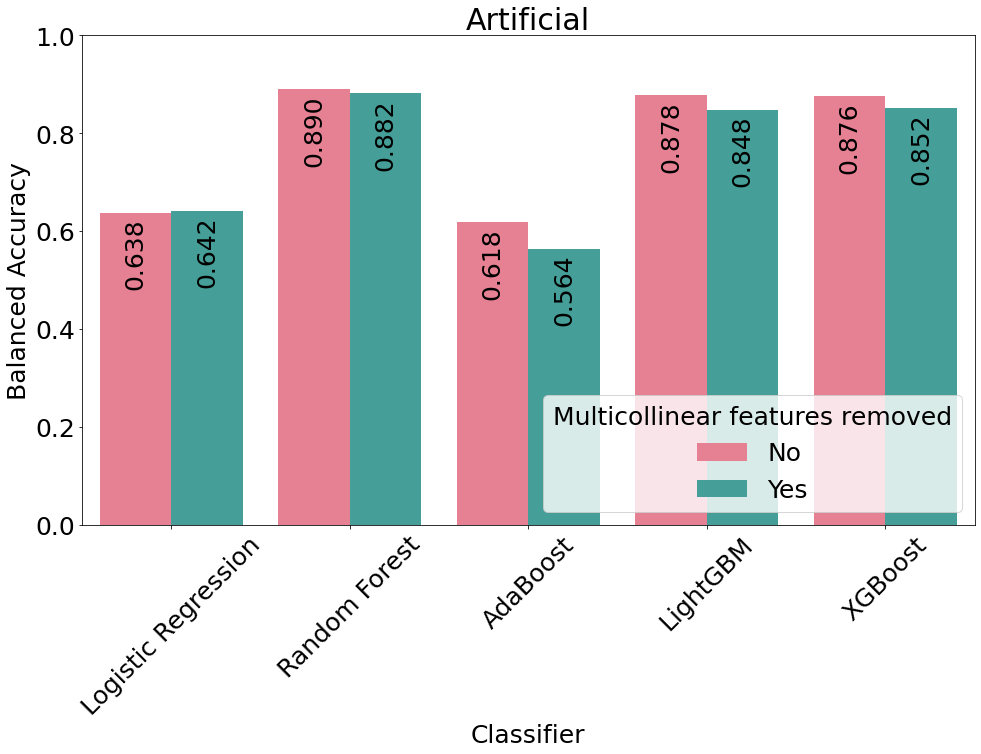

In [16]:
bars = sns.barplot(x='Classifier', y='BA score', hue='VIF', data=res_boruta_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Multicollinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
plt.title('Artificial')#\nClassifiers performance after Boruta feature selection')
plt.xticks(rotation=45)
plt.show()